In [1]:
import networkx as nx # version 2.2
import matplotlib.pyplot as plt
import re
import cvxpy as cp
import operator #to sort elements in a list of tuples
import itertools
import math
import numpy as np
import os
import sys
import time
import random

import Init_NetRate as Init
import cvxpy as cp
import Cascade_generation_functions_NetRate as Gen
import CVX_functions as cvx

In [52]:
'''
Create the matrix Mi for the ADMM method

Each cell k,l in Mi is one if in cascade k node l infected node i, 0 otherwise

Input :
    cascade_dic : a dictionnary of all cascade (in a graph object, DAG)
    node : an int describing which node we are considering in the ADMM iteration
    number_of_nodes : number of nodes in the underlying network (we assume that rhe union of all cascades cover all the nodes)
'''
def Create_matrix_Mi_and_Ti(cascade_dic,node,number_of_nodes,window) : 
    M_i = np.zeros((len(cascade_dic),number_of_nodes))
    T_i = np.zeros((len(cascade_dic),number_of_nodes))
    index_to_delete =[]
    for cascade in cascade_dic :
        c = cascade_dic[cascade] # graph object
        if node in c.nodes():
            t_i = c.node[node]["time"]
            parent_list = list(c.predecessors(node)) # create a list of all nodes (int) that where infected before node i in the cascade
            for parent in parent_list :
                t_parent = c.node[parent]["time"]
                M_i[cascade,parent] = 1
                T_i[cascade,parent] = (t_i-t_parent)
                if (t_i-t_parent)<=0:
                    print("Time error, the flow of time is reversed the world's end is near")
        else :
            for j in c.nodes() :
                t_j = c.node[j]["time"]
                T_i[cascade,j] = (window-t_j) # SIGNE is now correct !
                
        if np.all(M_i[cascade,:]==0):
            index_to_delete.append(cascade)
    M_i = np.delete(M_i,(index_to_delete),axis=0)
                
    return M_i,T_i


    

In [191]:
def Compute_objective_value_for_one_node(alpha_mat_i,cascade_dic,window,eps,node_i) :
    obj_i = 0
    for cascs in cascade_dic :
        c = cascade_dic[cascs]
        if node_i in c.nodes():
            t_i = c.nodes[node_i]["time"]
            parents_i_list = list(c.predecessors(node_i))
            sum_tmp = 0
            for parent in parents_i_list :
                t_parent = c.nodes[parent]["time"]
                obj_i += alpha_mat_i[parent]*(t_i-t_parent)
                sum_tmp += alpha_mat_i[parent]
            if sum_tmp<=0 :
                if len(parents_i_list)>0 :
#                     print("Attention log ill defined incoming")
                    obj_i -=math.log(eps)
            else :
                obj_i -= math.log(sum_tmp)
        else :
            for j in c.nodes():
                t_j = c.nodes[j]["time"]
                obj_i += alpha_mat_i[j]*(window-t_j)
    return obj_i

def Compute_true_objective_value_per_node(G_true,cascade_dic,window,node_i):
    obj_i = 0
    for cascs in cascade_dic :
        c = cascade_dic[cascs]
        if node_i in c.nodes():
            t_i = c.nodes[node_i]["time"]
            parent_i_list = list(c.predecessors(node_i))
            sum_tmp = 0
            for parent in parent_i_list :
                if (parent,node_i) in G_true.edges():
                    t_parent = c.nodes[parent]["time"]
                    try :
                        alpha_ji = G_true.edges[(parent,node_i)]["weight"][0]
                    except TypeError :
                        alpha_ji = G_true.edges[(parent,node_i)]["weight"]
                    obj_i += alpha_ji*(t_i-t_parent)
                    sum_tmp += alpha_ji
            if sum_tmp == 0:
                if len(parent_i_list)>0 :
                    print("Oulala")
            else :
                obj_i -= math.log(sum_tmp)
        else :
            for j in c.nodes() :
                if (j,i) in G_true.edges():
                    t_j = c.nodes[j]["time"]
                    try :
                        alpha_ji = G_true.edges[(j,i)]["weight"][0]
                    except TypeError :
                        alpha_ji = G_true.edges[(j,i)]["weight"]
                    obj_i += alpha_ji*(window-t_j)
    return obj_i

In [224]:
network_file_name = "./Graph_test_SG.txt"
cascade_file_name = "./Cascade_test_SG.txt"
window = 10
model=0 # not important but needed. When constructing the underlying network specify that we use the exponential law
beta = 1 # used for the construction of the cascades, probability of the edge to transmit the infection
eps = 0.0005
alpha_max = 10 #bound alpha from above
alpha_init = 0.01 #initial value of the infectious rates
iter_ADMM = 50 #number of itteration for 1 node in the ADMM method. This is a parameter to tune
iter_GD = 500 #number of iterations of the gradient descent
gamma = 0.00005 # Learning rate of the GD for alpha (maybe too small)
#gamma = 0.000005

In [239]:
G_true = Init.Load_ground_truth(network_file_name)
G_star, DAG_C_dic = Init.Init(cascade_file_name)
N = G_true.number_of_nodes()

# G_true = Gen.Generate_random_graph(30,60)
# Cascades = Gen.Generate_all_cascades(G_true,-1000,window,model,beta)
# Gen.Save_cascade_to_file("Cascade_test_ADMM.txt",Cascades,G_true)
# Gen.Save_graph_to_file("Graph_test_ADMM.txt",G_true)
# G_star,DAG_C_dic = Init.Init("Cascade_test_ADMM.txt")
# N = G_true.number_of_nodes()

All nodes were read


In [240]:
A_hat = np.zeros((N,N))
u = 4 # used for the gradient descent of rho and as a penalizer and the constrain


In [241]:
t_start_global = time.time()
dic_of_obj_per_node_per_iter = {}
obj_per_node = []
for i in G_true.nodes :
    print("Node : ",i)
    t_start_node_i = time.time()
    dic_of_obj_per_node_per_iter[i] = []
    
    
    '''
    initialization
    '''
    a_k = np.ones((N,1))*alpha_init
    a_k[i]=0
    M_i,T_i = Create_matrix_Mi_and_Ti(DAG_C_dic,i,N,window) # TO do : consider to use sparse matrix  
    grad_i = (np.sum(T_i,axis=0).T)
    for bla in range(0,len(grad_i)):
        if grad_i[bla]==0 :
            a_k[bla]=0
   
    z = a_k.copy()         
    rho = np.zeros((M_i.shape[0],1))
    S_i = np.matmul(M_i,z)
    
    has_converge=False
    k=0
    #Start iteration of ADMM
    while has_converge==False and k<iter_ADMM :
        '''
        Update alpha using gradient descent
        '''
        grad = grad_i + np.matmul(rho.T,M_i)
        for j in range(0,iter_GD):
            grad_j = grad - u*(np.matmul(M_i.T,(S_i-np.matmul(M_i,a_k))).T) # sign is correct
            a_k = a_k - gamma*grad_j.T
            a_k = np.maximum(a_k,0)
            a_k = np.minimum(a_k,alpha_max)
            
        '''
        update S_i and rho for each cascades via the closed form formula and the gradient descent respectively
        '''
        for cascs in range(0,M_i.shape[0]) :
            c = DAG_C_dic[cascs]
            Malpha = np.matmul(M_i[cascs,:],a_k)
#             Malpha = 0
#             if i in c.nodes :
#                 parent_i_c = list(c.predecessors(i))
#                 for papa in parent_i_c :
#                     Malpha += a_k[papa]
#             sqrt_delta = math.sqrt((rho[cascs]+Malpha)**2 + 4*u)
#             S_i[cascs] = ((rho[cascs]+Malpha)+sqrt_delta)/(2*u)
#             if i in c.nodes() and len(list(c.predecessors(i)))>0 :
            sqrt_delta = math.sqrt((rho[cascs]+u*Malpha)**2+4*u)
            S_i[cascs] = (rho[cascs]+u*Malpha + sqrt_delta)/(2*u)
            if S_i[cascs]<0 :
                print("Huston Huston we have a probleme")
            if S_i[cascs] ==0 :
                print("one component of S_i is zero")
#                 rho[cascs] = rho[cascs]-u*(S_i[cascs]-Malpha)
#             else :
#                 S_i[cascs] = (rho[cascs]+u*Malpha)/u

            rho[cascs] = rho[cascs]-u*(S_i[cascs]-Malpha)
            
        '''compute the objective function for node i in iteration k'''
        if k%5 ==0 :
            print(k)
            obj_i_k = Compute_objective_value_for_one_node(a_k,DAG_C_dic,window,eps,i)
            dic_of_obj_per_node_per_iter[i].append(obj_i_k)
        k+=1
        if len(dic_of_obj_per_node_per_iter[i])>=2:
            delta = abs(dic_of_obj_per_node_per_iter[i][-1]-dic_of_obj_per_node_per_iter[i][-2])
            if delta<1e-3 :
                has_converge=True
    A_hat[:,i] = a_k.flatten()
    t_end_node_i = time.time()
    print("computation time for node i : ", t_end_node_i-t_start_node_i)
t_end_global = time.time()
print("total computation time : ",t_end_global-t_start_global) 

Node :  0
0
5
10
15
20
25
computation time for node i :  1.9844765663146973
Node :  1
0
5
computation time for node i :  0.5882854461669922
Node :  2
0
5
10
computation time for node i :  1.0713143348693848
Node :  3
0
5
10
15
20
computation time for node i :  1.249422311782837
Node :  4
0
5
10
15
20
25
30
computation time for node i :  2.5663015842437744
Node :  5
0
5
10
15
20
computation time for node i :  1.7831182479858398
Node :  6
0
5
computation time for node i :  0.515838623046875
Node :  7
0
5
10
15
20
25
30
computation time for node i :  2.4115495681762695
Node :  8
0
5
10
15
20
computation time for node i :  1.903646469116211
Node :  9
0
5
10
15
20
25
30
computation time for node i :  2.44378924369812
Node :  10
0
5
10
computation time for node i :  1.0420949459075928
Node :  11
0
5
10
15
20
25
30
computation time for node i :  2.713613748550415
Node :  12
0
5
10
15
20
computation time for node i :  1.5713274478912354
Node :  13
0
5
10
15
20
25
30
35
40
computation time for 

computation time for node i :  3.465549945831299
Node :  109
0
5
10
15
20
25
30
35
40
45
computation time for node i :  4.127213001251221
Node :  110
0
5
computation time for node i :  0.568913459777832
Node :  111
0
5
10
15
20
25
computation time for node i :  2.141230583190918
Node :  112
0
5
computation time for node i :  0.5257594585418701
Node :  113
0
5
10
computation time for node i :  1.0787980556488037
Node :  114
0
5
10
15
computation time for node i :  1.2404980659484863
Node :  115
0
5
10
15
computation time for node i :  1.2409887313842773
Node :  116
0
5
10
15
20
25
30
computation time for node i :  2.4294047355651855
Node :  117
0
5
10
15
20
25
computation time for node i :  2.181903123855591
Node :  118
0
5
10
15
computation time for node i :  1.4448449611663818
Node :  119
0
5
10
15
20
25
30
computation time for node i :  2.651116371154785
Node :  120
0
5
10
15
20
25
computation time for node i :  1.375408411026001
Node :  121
0
5
computation time for node i :  0.46574

In [233]:
for i in range(0,A_hat.shape[0]):
    for j in range(0,A_hat.shape[1]) :
        if A_hat[i,j]==alpha_init:
            print(i,j)

In [242]:
'''
Precision and recall computation
'''
correct = 0
edge_G_star = list(G_star.edges())
G_star.remove_edges_from(edge_G_star)
for i in range(0,G_true.number_of_nodes()):
    for j in range(0,G_true.number_of_nodes()):
        if A_hat[i,j] >0:
            G_star.add_edge(i,j)
            if (i,j) in G_true.edges():
                correct +=1
#                 print("edge ",(i,j))
#                 print("alpha is ",A_hat[i,j])
print("Precision :",correct/G_star.number_of_edges())
print("Recall :",correct/G_true.number_of_edges())
print("Number of correct infered edges : ",correct)
print("Number of edges in G_hat :",G_star.number_of_edges())
print("Number of edges in the true network ",G_true.number_of_edges())
        

Precision : 0.888095238095238
Recall : 0.9325
Number of correct infered edges :  373
Number of edges in G_hat : 420
Number of edges in the true network  400


In [238]:
'''
mean square error
'''
mse = 0
nb_correcte_edges=0
for edge in G_true.edges():
    if edge in G_star.edges():
        nb_correcte_edges +=1
        try:
            true_alpha = G_true.edges[edge]["weight"][0]
        except TypeError:
            true_alpha = G_true.edges[edge]["weight"]
        approx_alpha = A_hat[edge[0],edge[1]]
        mse += pow((true_alpha-approx_alpha),2) # mean square error
#         print("For edge " + str(edge)+ " the true weight is : " + str(true_alpha))
#         print("For edge " + str(edge)+ " the approx weight is : " + str(approx_alpha))
try :
    mse = mse/nb_correcte_edges
except ZeroDivisionError:
    print ("There is no correct edge")
print(" Mean square error is : ",mse)

 Mean square error is :  0.0055293820326912015


In [213]:
true_total_obj = 0
true_obj_per_node = []
for i in G_true.nodes():
    obj_i = Compute_true_objective_value_per_node(G_true,DAG_C_dic,window,i)
    print("Node %i has objective value %f" %(i,obj_i))
    true_obj_per_node.append(obj_i)
    true_total_obj += obj_i
print("true objective value : ",true_total_obj)


total_obj = 0
obj_per_node = []
for i in G_true.nodes():
    alpha_mat_i = A_hat[:,i]
    obj_i = Compute_objective_value_for_one_node(alpha_mat_i,DAG_C_dic,window,eps,i)
    print("Node %i has objective value %f" %(i,obj_i))
    obj_per_node.append(obj_i)
    total_obj += obj_i
print("Infered objective value : ", total_obj)

Node 0 has objective value 130.840255
Node 1 has objective value 0.000000
Node 2 has objective value 662.817534
Node 3 has objective value 32.394744
Node 4 has objective value 693.260137
Node 5 has objective value 637.848855
Node 6 has objective value 25.030081
Node 7 has objective value 398.632000
Node 8 has objective value 843.062271
Node 9 has objective value 635.864726
Node 10 has objective value 498.218956
Node 11 has objective value 665.089551
Node 12 has objective value 267.145793
Node 13 has objective value 810.951177
Node 14 has objective value 115.492529
Node 15 has objective value 55.700474
Node 16 has objective value 432.475465
Node 17 has objective value 509.268177
Node 18 has objective value 23.503738
Node 19 has objective value 256.035816
Node 20 has objective value 0.000000
Node 21 has objective value 0.000000
Node 22 has objective value 0.000000
Node 23 has objective value 668.738137
Node 24 has objective value 775.408540
Node 25 has objective value 769.128807
Node 26 

Node 13 has objective value 808.116290
Node 14 has objective value 115.206614
Node 15 has objective value 55.057546
Node 16 has objective value 431.753074
Node 17 has objective value 507.611211
Node 18 has objective value 23.466532
Node 19 has objective value 255.851427
Node 20 has objective value 0.000000
Node 21 has objective value 0.000000
Node 22 has objective value 0.000000
Node 23 has objective value 668.231204
Node 24 has objective value 773.912343
Node 25 has objective value 768.467445
Node 26 has objective value 478.502955
Node 27 has objective value 826.533132
Node 28 has objective value 966.442396
Node 29 has objective value 469.838304
Node 30 has objective value -0.012086
Node 31 has objective value 388.789005
Node 32 has objective value 421.838213
Node 33 has objective value 626.106743
Node 34 has objective value 733.553007
Node 35 has objective value 1018.437338
Node 36 has objective value 672.591420
Node 37 has objective value 0.000000
Node 38 has objective value 830.484

In [214]:
(total_obj-true_total_obj)/true_total_obj

0.005580978312494292

Node :  53


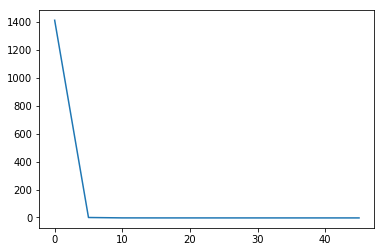

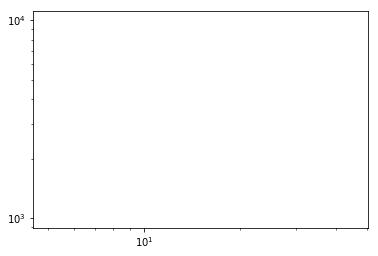

In [217]:
node_rand = random.choice(list(G_true.nodes()))
print("Node : ",node_rand)
x_axis = [x*5 for x in list(range(0,len(dic_of_obj_per_node_per_iter[node_rand])))]
true_obj_value_node = true_obj_per_node[node_rand]
bla = [x-true_obj_value_node for x in dic_of_obj_per_node_per_iter[node_rand]]
plt.plot(x_axis,bla)
plt.show()
plt.loglog(x_axis,bla)
plt.show()

In [216]:
bla

[array([74.01789006]),
 array([-0.89184373]),
 array([-1.70771606]),
 array([-1.7079331]),
 array([-1.70793477]),
 array([-1.70793477]),
 array([-1.70793477]),
 array([-1.70793477]),
 array([-1.70793477]),
 array([-1.70793477])]